# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

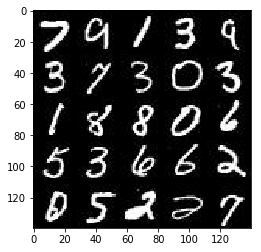

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

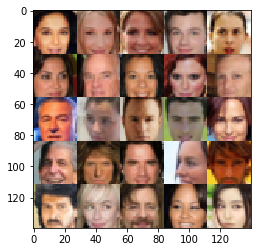

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_size = 5
    
    with tf.variable_scope('discriminator', reuse=reuse):
        layer_1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d(relu_1, 128, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        batch_normalized_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * batch_normalized_2, batch_normalized_2)
        
        layer_3 = tf.layers.conv2d(relu_2, 256, kernel_size, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        batch_normalized_3 = tf.layers.batch_normalization(layer_3, training=True)
        relu_3 = tf.maximum(alpha * batch_normalized_3, batch_normalized_3)
        
        flat = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.maximum(x*alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), padding='same')
        x = tf.maximum(x*alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
                
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), padding='same')
        x = tf.maximum(x*alpha, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.85):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    step = 0
    print_interval = 10
    show_interval = 100
    show_n_images = 25
    
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_i += 1
                
                # scale up image
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if not(step % print_interval):
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Batch {}/{}\t".format(batch_i, n_total_batches),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}\t".format(train_loss_g))
                    
                if not(step % show_interval):
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Batch 10/937	 Discriminator Loss: 1.2558	 Generator Loss: 1.5098	
Epoch 1/2	 Batch 20/937	 Discriminator Loss: 0.5801	 Generator Loss: 4.3086	
Epoch 1/2	 Batch 30/937	 Discriminator Loss: 0.7082	 Generator Loss: 2.0765	
Epoch 1/2	 Batch 40/937	 Discriminator Loss: 0.6376	 Generator Loss: 4.2742	
Epoch 1/2	 Batch 50/937	 Discriminator Loss: 0.7402	 Generator Loss: 2.0418	
Epoch 1/2	 Batch 60/937	 Discriminator Loss: 1.4207	 Generator Loss: 2.2127	
Epoch 1/2	 Batch 70/937	 Discriminator Loss: 2.0761	 Generator Loss: 2.0296	
Epoch 1/2	 Batch 80/937	 Discriminator Loss: 1.5650	 Generator Loss: 1.3704	
Epoch 1/2	 Batch 90/937	 Discriminator Loss: 1.2679	 Generator Loss: 0.9161	
Epoch 1/2	 Batch 100/937	 Discriminator Loss: 1.4696	 Generator Loss: 1.3345	


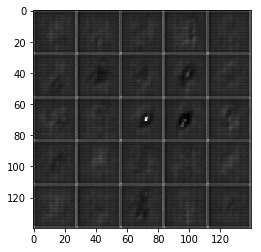

Epoch 1/2	 Batch 110/937	 Discriminator Loss: 1.3289	 Generator Loss: 0.6699	
Epoch 1/2	 Batch 120/937	 Discriminator Loss: 1.2813	 Generator Loss: 1.1123	
Epoch 1/2	 Batch 130/937	 Discriminator Loss: 1.3209	 Generator Loss: 0.6873	
Epoch 1/2	 Batch 140/937	 Discriminator Loss: 1.5359	 Generator Loss: 2.4873	
Epoch 1/2	 Batch 150/937	 Discriminator Loss: 1.4028	 Generator Loss: 0.6575	
Epoch 1/2	 Batch 160/937	 Discriminator Loss: 1.5077	 Generator Loss: 2.1631	
Epoch 1/2	 Batch 170/937	 Discriminator Loss: 1.3612	 Generator Loss: 2.5381	
Epoch 1/2	 Batch 180/937	 Discriminator Loss: 0.9275	 Generator Loss: 1.8378	
Epoch 1/2	 Batch 190/937	 Discriminator Loss: 1.1798	 Generator Loss: 0.8019	
Epoch 1/2	 Batch 200/937	 Discriminator Loss: 2.4024	 Generator Loss: 4.6730	


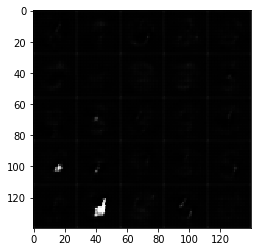

Epoch 1/2	 Batch 210/937	 Discriminator Loss: 1.3156	 Generator Loss: 0.6870	
Epoch 1/2	 Batch 220/937	 Discriminator Loss: 0.9818	 Generator Loss: 1.2054	
Epoch 1/2	 Batch 230/937	 Discriminator Loss: 1.7311	 Generator Loss: 0.3640	
Epoch 1/2	 Batch 240/937	 Discriminator Loss: 1.0624	 Generator Loss: 1.7210	
Epoch 1/2	 Batch 250/937	 Discriminator Loss: 1.2023	 Generator Loss: 0.7909	
Epoch 1/2	 Batch 260/937	 Discriminator Loss: 1.0788	 Generator Loss: 1.5272	
Epoch 1/2	 Batch 270/937	 Discriminator Loss: 2.2105	 Generator Loss: 3.3122	
Epoch 1/2	 Batch 280/937	 Discriminator Loss: 1.0796	 Generator Loss: 1.1776	
Epoch 1/2	 Batch 290/937	 Discriminator Loss: 0.9690	 Generator Loss: 1.6278	
Epoch 1/2	 Batch 300/937	 Discriminator Loss: 1.0970	 Generator Loss: 2.5202	


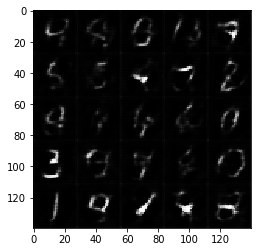

Epoch 1/2	 Batch 310/937	 Discriminator Loss: 1.4382	 Generator Loss: 0.5753	
Epoch 1/2	 Batch 320/937	 Discriminator Loss: 1.1780	 Generator Loss: 0.8321	
Epoch 1/2	 Batch 330/937	 Discriminator Loss: 1.0314	 Generator Loss: 0.9724	
Epoch 1/2	 Batch 340/937	 Discriminator Loss: 1.0692	 Generator Loss: 1.1964	
Epoch 1/2	 Batch 350/937	 Discriminator Loss: 1.1764	 Generator Loss: 1.7641	
Epoch 1/2	 Batch 360/937	 Discriminator Loss: 1.1995	 Generator Loss: 0.7912	
Epoch 1/2	 Batch 370/937	 Discriminator Loss: 2.6574	 Generator Loss: 3.8288	
Epoch 1/2	 Batch 380/937	 Discriminator Loss: 1.1096	 Generator Loss: 1.0422	
Epoch 1/2	 Batch 390/937	 Discriminator Loss: 1.3140	 Generator Loss: 0.6045	
Epoch 1/2	 Batch 400/937	 Discriminator Loss: 1.5465	 Generator Loss: 0.4757	


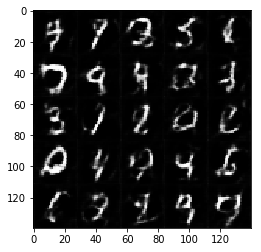

Epoch 1/2	 Batch 410/937	 Discriminator Loss: 1.5516	 Generator Loss: 2.1611	
Epoch 1/2	 Batch 420/937	 Discriminator Loss: 1.1812	 Generator Loss: 0.7712	
Epoch 1/2	 Batch 430/937	 Discriminator Loss: 2.0286	 Generator Loss: 0.2964	
Epoch 1/2	 Batch 440/937	 Discriminator Loss: 1.1492	 Generator Loss: 1.0567	
Epoch 1/2	 Batch 450/937	 Discriminator Loss: 1.1164	 Generator Loss: 0.7999	
Epoch 1/2	 Batch 460/937	 Discriminator Loss: 1.1046	 Generator Loss: 0.9763	
Epoch 1/2	 Batch 470/937	 Discriminator Loss: 1.2411	 Generator Loss: 2.5078	
Epoch 1/2	 Batch 480/937	 Discriminator Loss: 1.1873	 Generator Loss: 0.8163	
Epoch 1/2	 Batch 490/937	 Discriminator Loss: 1.1813	 Generator Loss: 1.7354	
Epoch 1/2	 Batch 500/937	 Discriminator Loss: 1.0152	 Generator Loss: 0.9605	


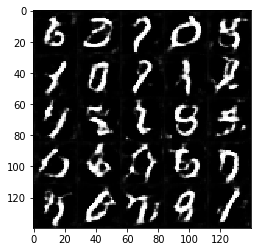

Epoch 1/2	 Batch 510/937	 Discriminator Loss: 1.8304	 Generator Loss: 0.4035	
Epoch 1/2	 Batch 520/937	 Discriminator Loss: 1.1796	 Generator Loss: 0.7549	
Epoch 1/2	 Batch 530/937	 Discriminator Loss: 1.3411	 Generator Loss: 0.6172	
Epoch 1/2	 Batch 540/937	 Discriminator Loss: 1.6709	 Generator Loss: 0.4312	
Epoch 1/2	 Batch 550/937	 Discriminator Loss: 1.3831	 Generator Loss: 0.5971	
Epoch 1/2	 Batch 560/937	 Discriminator Loss: 1.8989	 Generator Loss: 0.3413	
Epoch 1/2	 Batch 570/937	 Discriminator Loss: 1.2394	 Generator Loss: 0.6998	
Epoch 1/2	 Batch 580/937	 Discriminator Loss: 1.0262	 Generator Loss: 1.3413	
Epoch 1/2	 Batch 590/937	 Discriminator Loss: 1.5706	 Generator Loss: 0.4715	
Epoch 1/2	 Batch 600/937	 Discriminator Loss: 1.1179	 Generator Loss: 0.8509	


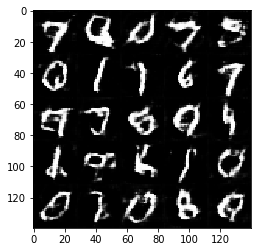

Epoch 1/2	 Batch 610/937	 Discriminator Loss: 0.8972	 Generator Loss: 1.2528	
Epoch 1/2	 Batch 620/937	 Discriminator Loss: 1.5901	 Generator Loss: 0.7704	
Epoch 1/2	 Batch 630/937	 Discriminator Loss: 1.0839	 Generator Loss: 1.4889	
Epoch 1/2	 Batch 640/937	 Discriminator Loss: 1.4347	 Generator Loss: 0.5261	
Epoch 1/2	 Batch 650/937	 Discriminator Loss: 1.0866	 Generator Loss: 0.9025	
Epoch 1/2	 Batch 660/937	 Discriminator Loss: 1.0834	 Generator Loss: 1.1641	
Epoch 1/2	 Batch 670/937	 Discriminator Loss: 1.2614	 Generator Loss: 0.6811	
Epoch 1/2	 Batch 680/937	 Discriminator Loss: 0.9696	 Generator Loss: 1.0174	
Epoch 1/2	 Batch 690/937	 Discriminator Loss: 1.1673	 Generator Loss: 0.8740	
Epoch 1/2	 Batch 700/937	 Discriminator Loss: 1.2921	 Generator Loss: 0.7804	


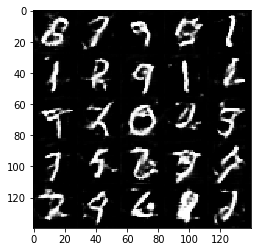

Epoch 1/2	 Batch 710/937	 Discriminator Loss: 1.0739	 Generator Loss: 1.4415	
Epoch 1/2	 Batch 720/937	 Discriminator Loss: 1.1958	 Generator Loss: 1.7798	
Epoch 1/2	 Batch 730/937	 Discriminator Loss: 1.0949	 Generator Loss: 0.8744	
Epoch 1/2	 Batch 740/937	 Discriminator Loss: 1.1168	 Generator Loss: 1.8678	
Epoch 1/2	 Batch 750/937	 Discriminator Loss: 0.9176	 Generator Loss: 1.4989	
Epoch 1/2	 Batch 760/937	 Discriminator Loss: 1.0203	 Generator Loss: 1.3722	
Epoch 1/2	 Batch 770/937	 Discriminator Loss: 2.2801	 Generator Loss: 0.2703	
Epoch 1/2	 Batch 780/937	 Discriminator Loss: 1.0318	 Generator Loss: 1.5446	
Epoch 1/2	 Batch 790/937	 Discriminator Loss: 0.9859	 Generator Loss: 1.1789	
Epoch 1/2	 Batch 800/937	 Discriminator Loss: 0.9935	 Generator Loss: 1.0287	


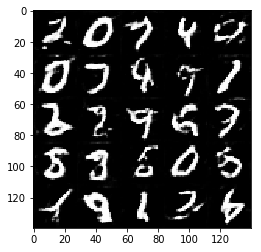

Epoch 1/2	 Batch 810/937	 Discriminator Loss: 1.1884	 Generator Loss: 2.0238	
Epoch 1/2	 Batch 820/937	 Discriminator Loss: 0.9956	 Generator Loss: 1.1835	
Epoch 1/2	 Batch 830/937	 Discriminator Loss: 1.1512	 Generator Loss: 1.7779	
Epoch 1/2	 Batch 840/937	 Discriminator Loss: 0.9563	 Generator Loss: 1.1215	
Epoch 1/2	 Batch 850/937	 Discriminator Loss: 1.2070	 Generator Loss: 0.7577	
Epoch 1/2	 Batch 860/937	 Discriminator Loss: 1.0281	 Generator Loss: 2.2196	
Epoch 1/2	 Batch 870/937	 Discriminator Loss: 1.0170	 Generator Loss: 1.0133	
Epoch 1/2	 Batch 880/937	 Discriminator Loss: 1.9055	 Generator Loss: 2.8614	
Epoch 1/2	 Batch 890/937	 Discriminator Loss: 1.0564	 Generator Loss: 1.2993	
Epoch 1/2	 Batch 900/937	 Discriminator Loss: 1.0293	 Generator Loss: 1.0671	


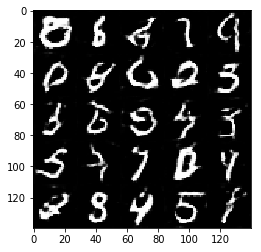

Epoch 1/2	 Batch 910/937	 Discriminator Loss: 0.9609	 Generator Loss: 1.3055	
Epoch 1/2	 Batch 920/937	 Discriminator Loss: 0.8868	 Generator Loss: 1.3711	
Epoch 1/2	 Batch 930/937	 Discriminator Loss: 0.9020	 Generator Loss: 1.2931	
Epoch 2/2	 Batch 3/937	 Discriminator Loss: 1.1093	 Generator Loss: 1.7008	
Epoch 2/2	 Batch 13/937	 Discriminator Loss: 1.1640	 Generator Loss: 0.8072	
Epoch 2/2	 Batch 23/937	 Discriminator Loss: 1.4573	 Generator Loss: 2.8336	
Epoch 2/2	 Batch 33/937	 Discriminator Loss: 0.8498	 Generator Loss: 1.6557	
Epoch 2/2	 Batch 43/937	 Discriminator Loss: 0.7914	 Generator Loss: 1.6473	
Epoch 2/2	 Batch 53/937	 Discriminator Loss: 1.1628	 Generator Loss: 0.8265	
Epoch 2/2	 Batch 63/937	 Discriminator Loss: 0.9159	 Generator Loss: 1.5006	


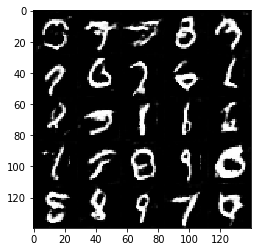

Epoch 2/2	 Batch 73/937	 Discriminator Loss: 0.9516	 Generator Loss: 1.5339	
Epoch 2/2	 Batch 83/937	 Discriminator Loss: 1.0182	 Generator Loss: 1.2104	
Epoch 2/2	 Batch 93/937	 Discriminator Loss: 1.0460	 Generator Loss: 0.9209	
Epoch 2/2	 Batch 103/937	 Discriminator Loss: 1.1000	 Generator Loss: 0.9368	
Epoch 2/2	 Batch 113/937	 Discriminator Loss: 1.5748	 Generator Loss: 0.5549	
Epoch 2/2	 Batch 123/937	 Discriminator Loss: 0.7058	 Generator Loss: 1.7408	
Epoch 2/2	 Batch 133/937	 Discriminator Loss: 0.8639	 Generator Loss: 1.5312	
Epoch 2/2	 Batch 143/937	 Discriminator Loss: 1.0719	 Generator Loss: 1.7823	
Epoch 2/2	 Batch 153/937	 Discriminator Loss: 1.6594	 Generator Loss: 0.4810	
Epoch 2/2	 Batch 163/937	 Discriminator Loss: 0.9215	 Generator Loss: 1.5082	


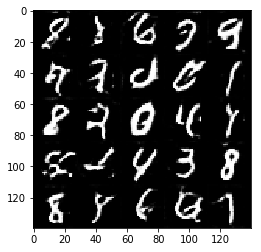

Epoch 2/2	 Batch 173/937	 Discriminator Loss: 1.1789	 Generator Loss: 0.7989	
Epoch 2/2	 Batch 183/937	 Discriminator Loss: 1.0728	 Generator Loss: 2.6793	
Epoch 2/2	 Batch 193/937	 Discriminator Loss: 1.0166	 Generator Loss: 1.1336	
Epoch 2/2	 Batch 203/937	 Discriminator Loss: 0.7091	 Generator Loss: 2.3500	
Epoch 2/2	 Batch 213/937	 Discriminator Loss: 1.1367	 Generator Loss: 0.8440	
Epoch 2/2	 Batch 223/937	 Discriminator Loss: 0.9743	 Generator Loss: 1.7229	
Epoch 2/2	 Batch 233/937	 Discriminator Loss: 1.0485	 Generator Loss: 1.0227	
Epoch 2/2	 Batch 243/937	 Discriminator Loss: 1.1682	 Generator Loss: 0.9237	
Epoch 2/2	 Batch 253/937	 Discriminator Loss: 1.1988	 Generator Loss: 0.9606	
Epoch 2/2	 Batch 263/937	 Discriminator Loss: 1.1927	 Generator Loss: 0.7511	


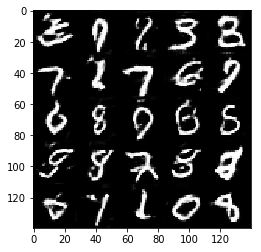

Epoch 2/2	 Batch 273/937	 Discriminator Loss: 1.1123	 Generator Loss: 0.8549	
Epoch 2/2	 Batch 283/937	 Discriminator Loss: 1.2454	 Generator Loss: 0.6896	
Epoch 2/2	 Batch 293/937	 Discriminator Loss: 1.0887	 Generator Loss: 1.0248	
Epoch 2/2	 Batch 303/937	 Discriminator Loss: 1.0551	 Generator Loss: 1.5274	
Epoch 2/2	 Batch 313/937	 Discriminator Loss: 0.8090	 Generator Loss: 1.4063	
Epoch 2/2	 Batch 323/937	 Discriminator Loss: 1.2308	 Generator Loss: 0.8091	
Epoch 2/2	 Batch 333/937	 Discriminator Loss: 0.9549	 Generator Loss: 1.3937	
Epoch 2/2	 Batch 343/937	 Discriminator Loss: 1.1220	 Generator Loss: 0.8691	
Epoch 2/2	 Batch 363/937	 Discriminator Loss: 1.0258	 Generator Loss: 0.9985	


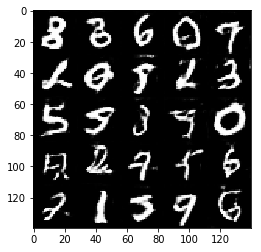

Epoch 2/2	 Batch 373/937	 Discriminator Loss: 1.0927	 Generator Loss: 0.8710	
Epoch 2/2	 Batch 383/937	 Discriminator Loss: 0.8604	 Generator Loss: 1.6491	
Epoch 2/2	 Batch 393/937	 Discriminator Loss: 0.9417	 Generator Loss: 1.5446	
Epoch 2/2	 Batch 403/937	 Discriminator Loss: 1.0147	 Generator Loss: 1.1154	
Epoch 2/2	 Batch 413/937	 Discriminator Loss: 1.2041	 Generator Loss: 0.7918	
Epoch 2/2	 Batch 423/937	 Discriminator Loss: 1.0480	 Generator Loss: 1.2375	
Epoch 2/2	 Batch 433/937	 Discriminator Loss: 1.1122	 Generator Loss: 0.8890	
Epoch 2/2	 Batch 443/937	 Discriminator Loss: 0.9764	 Generator Loss: 1.1264	
Epoch 2/2	 Batch 453/937	 Discriminator Loss: 1.1459	 Generator Loss: 0.8717	
Epoch 2/2	 Batch 463/937	 Discriminator Loss: 0.9968	 Generator Loss: 1.1721	


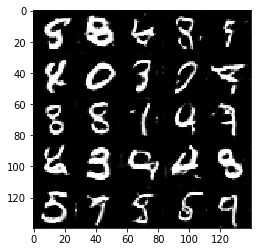

Epoch 2/2	 Batch 473/937	 Discriminator Loss: 0.7548	 Generator Loss: 2.1296	
Epoch 2/2	 Batch 483/937	 Discriminator Loss: 0.8870	 Generator Loss: 1.1827	
Epoch 2/2	 Batch 493/937	 Discriminator Loss: 0.9875	 Generator Loss: 1.5086	
Epoch 2/2	 Batch 503/937	 Discriminator Loss: 1.0667	 Generator Loss: 0.9784	
Epoch 2/2	 Batch 513/937	 Discriminator Loss: 1.1700	 Generator Loss: 0.8964	
Epoch 2/2	 Batch 523/937	 Discriminator Loss: 0.8390	 Generator Loss: 2.2327	
Epoch 2/2	 Batch 533/937	 Discriminator Loss: 0.9206	 Generator Loss: 1.2820	
Epoch 2/2	 Batch 543/937	 Discriminator Loss: 1.0292	 Generator Loss: 2.0432	
Epoch 2/2	 Batch 553/937	 Discriminator Loss: 1.0227	 Generator Loss: 1.0544	
Epoch 2/2	 Batch 563/937	 Discriminator Loss: 0.9922	 Generator Loss: 1.5932	


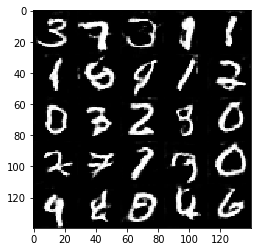

Epoch 2/2	 Batch 573/937	 Discriminator Loss: 0.9032	 Generator Loss: 1.3534	
Epoch 2/2	 Batch 583/937	 Discriminator Loss: 1.1043	 Generator Loss: 0.9570	
Epoch 2/2	 Batch 593/937	 Discriminator Loss: 1.2042	 Generator Loss: 0.8998	
Epoch 2/2	 Batch 603/937	 Discriminator Loss: 1.2397	 Generator Loss: 0.9789	
Epoch 2/2	 Batch 613/937	 Discriminator Loss: 0.7344	 Generator Loss: 2.0159	
Epoch 2/2	 Batch 623/937	 Discriminator Loss: 1.6730	 Generator Loss: 0.5653	
Epoch 2/2	 Batch 633/937	 Discriminator Loss: 0.9332	 Generator Loss: 1.3190	
Epoch 2/2	 Batch 643/937	 Discriminator Loss: 0.8098	 Generator Loss: 1.3786	
Epoch 2/2	 Batch 653/937	 Discriminator Loss: 1.2211	 Generator Loss: 2.1030	
Epoch 2/2	 Batch 663/937	 Discriminator Loss: 1.4200	 Generator Loss: 2.3099	


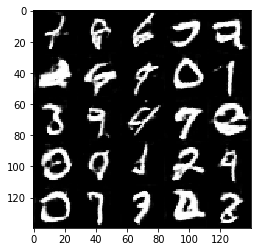

Epoch 2/2	 Batch 673/937	 Discriminator Loss: 0.9530	 Generator Loss: 1.1421	
Epoch 2/2	 Batch 683/937	 Discriminator Loss: 1.2855	 Generator Loss: 0.7327	
Epoch 2/2	 Batch 693/937	 Discriminator Loss: 0.8232	 Generator Loss: 1.5179	
Epoch 2/2	 Batch 703/937	 Discriminator Loss: 0.8984	 Generator Loss: 2.4103	
Epoch 2/2	 Batch 713/937	 Discriminator Loss: 0.8922	 Generator Loss: 1.3013	
Epoch 2/2	 Batch 723/937	 Discriminator Loss: 0.8700	 Generator Loss: 1.5805	
Epoch 2/2	 Batch 733/937	 Discriminator Loss: 1.0642	 Generator Loss: 0.9626	
Epoch 2/2	 Batch 743/937	 Discriminator Loss: 1.4642	 Generator Loss: 0.6067	
Epoch 2/2	 Batch 753/937	 Discriminator Loss: 0.9808	 Generator Loss: 1.2109	
Epoch 2/2	 Batch 763/937	 Discriminator Loss: 0.8600	 Generator Loss: 1.3835	


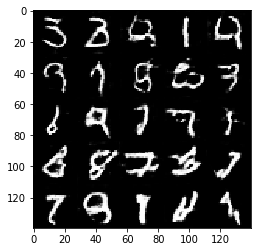

Epoch 2/2	 Batch 773/937	 Discriminator Loss: 1.0185	 Generator Loss: 0.9611	
Epoch 2/2	 Batch 783/937	 Discriminator Loss: 0.9287	 Generator Loss: 1.4363	
Epoch 2/2	 Batch 793/937	 Discriminator Loss: 1.1707	 Generator Loss: 2.3736	
Epoch 2/2	 Batch 803/937	 Discriminator Loss: 0.9806	 Generator Loss: 1.1005	
Epoch 2/2	 Batch 813/937	 Discriminator Loss: 1.1259	 Generator Loss: 2.3962	
Epoch 2/2	 Batch 823/937	 Discriminator Loss: 0.9604	 Generator Loss: 1.3489	
Epoch 2/2	 Batch 833/937	 Discriminator Loss: 0.8186	 Generator Loss: 1.7821	
Epoch 2/2	 Batch 843/937	 Discriminator Loss: 0.7135	 Generator Loss: 1.7109	
Epoch 2/2	 Batch 853/937	 Discriminator Loss: 0.8784	 Generator Loss: 2.2958	
Epoch 2/2	 Batch 863/937	 Discriminator Loss: 0.8283	 Generator Loss: 1.4429	


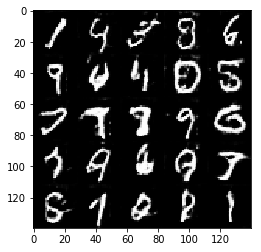

Epoch 2/2	 Batch 873/937	 Discriminator Loss: 0.7848	 Generator Loss: 1.5873	
Epoch 2/2	 Batch 883/937	 Discriminator Loss: 1.7704	 Generator Loss: 0.4770	
Epoch 2/2	 Batch 893/937	 Discriminator Loss: 1.2384	 Generator Loss: 0.8232	
Epoch 2/2	 Batch 903/937	 Discriminator Loss: 0.8681	 Generator Loss: 1.4699	
Epoch 2/2	 Batch 913/937	 Discriminator Loss: 0.6206	 Generator Loss: 2.2174	
Epoch 2/2	 Batch 923/937	 Discriminator Loss: 1.0888	 Generator Loss: 0.9937	
Epoch 2/2	 Batch 933/937	 Discriminator Loss: 0.8949	 Generator Loss: 1.1961	


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1	 Batch 10/1582	 Discriminator Loss: 1.2720	 Generator Loss: 7.8187	
Epoch 1/1	 Batch 20/1582	 Discriminator Loss: 3.3761	 Generator Loss: 0.1162	
Epoch 1/1	 Batch 30/1582	 Discriminator Loss: 1.3825	 Generator Loss: 0.5997	
Epoch 1/1	 Batch 40/1582	 Discriminator Loss: 0.7474	 Generator Loss: 1.8505	
Epoch 1/1	 Batch 50/1582	 Discriminator Loss: 0.9752	 Generator Loss: 2.0761	
Epoch 1/1	 Batch 60/1582	 Discriminator Loss: 0.5714	 Generator Loss: 4.9733	
Epoch 1/1	 Batch 70/1582	 Discriminator Loss: 1.4037	 Generator Loss: 0.5877	
Epoch 1/1	 Batch 80/1582	 Discriminator Loss: 1.7318	 Generator Loss: 0.4662	
Epoch 1/1	 Batch 90/1582	 Discriminator Loss: 1.5228	 Generator Loss: 0.5663	
Epoch 1/1	 Batch 100/1582	 Discriminator Loss: 1.5033	 Generator Loss: 2.1371	


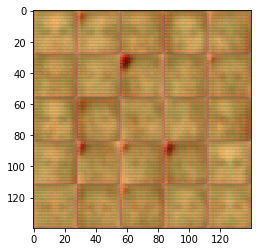

Epoch 1/1	 Batch 110/1582	 Discriminator Loss: 1.7886	 Generator Loss: 1.9855	
Epoch 1/1	 Batch 120/1582	 Discriminator Loss: 1.4345	 Generator Loss: 1.4143	
Epoch 1/1	 Batch 130/1582	 Discriminator Loss: 1.2745	 Generator Loss: 1.1654	
Epoch 1/1	 Batch 140/1582	 Discriminator Loss: 1.0676	 Generator Loss: 1.1542	
Epoch 1/1	 Batch 150/1582	 Discriminator Loss: 1.5177	 Generator Loss: 1.1479	
Epoch 1/1	 Batch 160/1582	 Discriminator Loss: 1.4251	 Generator Loss: 0.9175	
Epoch 1/1	 Batch 170/1582	 Discriminator Loss: 1.5420	 Generator Loss: 1.4489	
Epoch 1/1	 Batch 180/1582	 Discriminator Loss: 1.4252	 Generator Loss: 1.0565	
Epoch 1/1	 Batch 190/1582	 Discriminator Loss: 1.2665	 Generator Loss: 0.9854	
Epoch 1/1	 Batch 200/1582	 Discriminator Loss: 1.9996	 Generator Loss: 1.4591	


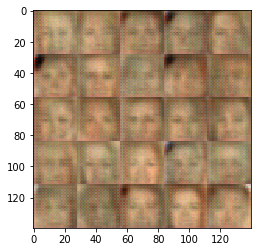

Epoch 1/1	 Batch 210/1582	 Discriminator Loss: 1.2260	 Generator Loss: 0.7591	
Epoch 1/1	 Batch 220/1582	 Discriminator Loss: 1.5045	 Generator Loss: 0.5676	
Epoch 1/1	 Batch 230/1582	 Discriminator Loss: 1.3318	 Generator Loss: 0.6624	
Epoch 1/1	 Batch 240/1582	 Discriminator Loss: 1.3868	 Generator Loss: 1.3620	
Epoch 1/1	 Batch 250/1582	 Discriminator Loss: 1.5034	 Generator Loss: 0.8365	
Epoch 1/1	 Batch 260/1582	 Discriminator Loss: 1.3164	 Generator Loss: 0.8401	
Epoch 1/1	 Batch 270/1582	 Discriminator Loss: 1.5710	 Generator Loss: 0.4642	
Epoch 1/1	 Batch 280/1582	 Discriminator Loss: 1.4884	 Generator Loss: 0.4971	
Epoch 1/1	 Batch 290/1582	 Discriminator Loss: 1.7129	 Generator Loss: 0.3562	
Epoch 1/1	 Batch 300/1582	 Discriminator Loss: 1.4243	 Generator Loss: 0.9435	


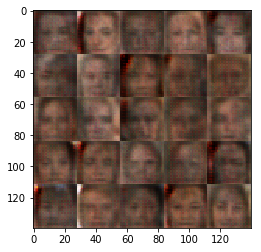

Epoch 1/1	 Batch 310/1582	 Discriminator Loss: 1.4142	 Generator Loss: 0.5895	
Epoch 1/1	 Batch 320/1582	 Discriminator Loss: 1.5163	 Generator Loss: 0.6799	
Epoch 1/1	 Batch 330/1582	 Discriminator Loss: 1.4047	 Generator Loss: 0.6635	
Epoch 1/1	 Batch 340/1582	 Discriminator Loss: 1.4672	 Generator Loss: 0.7521	
Epoch 1/1	 Batch 350/1582	 Discriminator Loss: 1.3929	 Generator Loss: 0.8450	
Epoch 1/1	 Batch 360/1582	 Discriminator Loss: 1.3923	 Generator Loss: 0.8958	
Epoch 1/1	 Batch 370/1582	 Discriminator Loss: 1.3696	 Generator Loss: 0.8172	
Epoch 1/1	 Batch 380/1582	 Discriminator Loss: 1.4963	 Generator Loss: 1.1978	
Epoch 1/1	 Batch 390/1582	 Discriminator Loss: 1.4013	 Generator Loss: 1.3170	
Epoch 1/1	 Batch 400/1582	 Discriminator Loss: 1.4116	 Generator Loss: 0.6240	


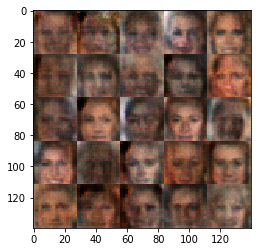

Epoch 1/1	 Batch 410/1582	 Discriminator Loss: 1.3261	 Generator Loss: 0.8439	
Epoch 1/1	 Batch 420/1582	 Discriminator Loss: 1.3091	 Generator Loss: 0.8673	
Epoch 1/1	 Batch 430/1582	 Discriminator Loss: 1.5539	 Generator Loss: 0.5326	
Epoch 1/1	 Batch 440/1582	 Discriminator Loss: 1.3551	 Generator Loss: 0.8122	
Epoch 1/1	 Batch 450/1582	 Discriminator Loss: 1.4131	 Generator Loss: 0.9909	
Epoch 1/1	 Batch 460/1582	 Discriminator Loss: 2.4781	 Generator Loss: 2.6815	
Epoch 1/1	 Batch 470/1582	 Discriminator Loss: 1.3785	 Generator Loss: 1.1093	
Epoch 1/1	 Batch 480/1582	 Discriminator Loss: 1.3811	 Generator Loss: 1.0327	
Epoch 1/1	 Batch 490/1582	 Discriminator Loss: 1.4624	 Generator Loss: 0.6175	
Epoch 1/1	 Batch 500/1582	 Discriminator Loss: 1.4727	 Generator Loss: 0.6146	


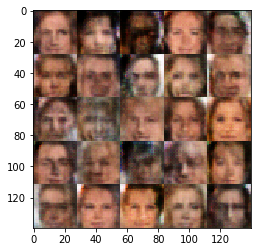

Epoch 1/1	 Batch 510/1582	 Discriminator Loss: 1.3364	 Generator Loss: 0.8522	
Epoch 1/1	 Batch 520/1582	 Discriminator Loss: 1.3742	 Generator Loss: 0.7065	
Epoch 1/1	 Batch 530/1582	 Discriminator Loss: 1.3324	 Generator Loss: 0.7084	
Epoch 1/1	 Batch 540/1582	 Discriminator Loss: 1.4054	 Generator Loss: 0.8902	
Epoch 1/1	 Batch 550/1582	 Discriminator Loss: 1.3907	 Generator Loss: 1.4870	
Epoch 1/1	 Batch 560/1582	 Discriminator Loss: 1.3036	 Generator Loss: 1.4772	
Epoch 1/1	 Batch 570/1582	 Discriminator Loss: 1.3962	 Generator Loss: 1.2496	
Epoch 1/1	 Batch 580/1582	 Discriminator Loss: 1.4385	 Generator Loss: 1.2093	
Epoch 1/1	 Batch 590/1582	 Discriminator Loss: 1.4512	 Generator Loss: 0.8593	
Epoch 1/1	 Batch 600/1582	 Discriminator Loss: 1.4785	 Generator Loss: 0.5685	


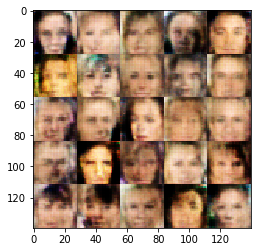

Epoch 1/1	 Batch 610/1582	 Discriminator Loss: 1.5114	 Generator Loss: 0.5079	
Epoch 1/1	 Batch 620/1582	 Discriminator Loss: 1.2453	 Generator Loss: 0.8508	
Epoch 1/1	 Batch 630/1582	 Discriminator Loss: 1.3954	 Generator Loss: 1.1442	
Epoch 1/1	 Batch 640/1582	 Discriminator Loss: 1.3211	 Generator Loss: 0.8357	
Epoch 1/1	 Batch 650/1582	 Discriminator Loss: 1.3976	 Generator Loss: 1.0560	
Epoch 1/1	 Batch 660/1582	 Discriminator Loss: 1.2549	 Generator Loss: 0.9218	
Epoch 1/1	 Batch 670/1582	 Discriminator Loss: 1.4648	 Generator Loss: 1.0036	
Epoch 1/1	 Batch 680/1582	 Discriminator Loss: 1.4199	 Generator Loss: 0.7003	
Epoch 1/1	 Batch 690/1582	 Discriminator Loss: 1.4024	 Generator Loss: 0.6527	
Epoch 1/1	 Batch 700/1582	 Discriminator Loss: 1.3841	 Generator Loss: 0.9058	


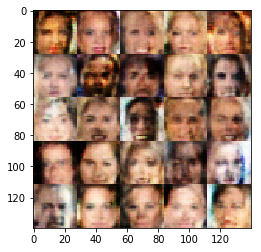

Epoch 1/1	 Batch 710/1582	 Discriminator Loss: 1.4102	 Generator Loss: 1.1269	
Epoch 1/1	 Batch 720/1582	 Discriminator Loss: 1.3757	 Generator Loss: 0.8565	
Epoch 1/1	 Batch 730/1582	 Discriminator Loss: 1.3077	 Generator Loss: 0.9379	
Epoch 1/1	 Batch 740/1582	 Discriminator Loss: 1.3153	 Generator Loss: 0.9036	
Epoch 1/1	 Batch 750/1582	 Discriminator Loss: 1.2507	 Generator Loss: 0.8105	
Epoch 1/1	 Batch 760/1582	 Discriminator Loss: 1.4350	 Generator Loss: 0.7234	
Epoch 1/1	 Batch 770/1582	 Discriminator Loss: 1.4525	 Generator Loss: 0.5697	
Epoch 1/1	 Batch 780/1582	 Discriminator Loss: 1.3975	 Generator Loss: 1.0093	
Epoch 1/1	 Batch 790/1582	 Discriminator Loss: 1.3544	 Generator Loss: 0.8179	
Epoch 1/1	 Batch 800/1582	 Discriminator Loss: 1.4902	 Generator Loss: 1.3503	


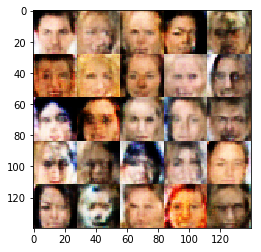

Epoch 1/1	 Batch 810/1582	 Discriminator Loss: 1.4324	 Generator Loss: 1.2700	
Epoch 1/1	 Batch 820/1582	 Discriminator Loss: 1.4323	 Generator Loss: 1.0978	
Epoch 1/1	 Batch 830/1582	 Discriminator Loss: 1.3019	 Generator Loss: 0.8460	
Epoch 1/1	 Batch 840/1582	 Discriminator Loss: 1.4578	 Generator Loss: 0.5794	
Epoch 1/1	 Batch 850/1582	 Discriminator Loss: 1.3448	 Generator Loss: 0.8963	
Epoch 1/1	 Batch 860/1582	 Discriminator Loss: 1.3853	 Generator Loss: 0.8658	
Epoch 1/1	 Batch 870/1582	 Discriminator Loss: 1.3834	 Generator Loss: 0.9142	
Epoch 1/1	 Batch 880/1582	 Discriminator Loss: 1.3214	 Generator Loss: 0.8311	
Epoch 1/1	 Batch 890/1582	 Discriminator Loss: 1.4379	 Generator Loss: 0.5529	
Epoch 1/1	 Batch 900/1582	 Discriminator Loss: 1.4187	 Generator Loss: 0.6094	


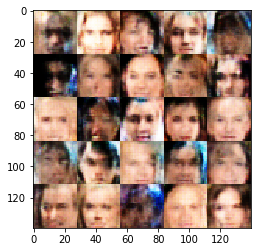

Epoch 1/1	 Batch 910/1582	 Discriminator Loss: 1.4040	 Generator Loss: 0.7686	
Epoch 1/1	 Batch 920/1582	 Discriminator Loss: 1.3611	 Generator Loss: 0.7730	
Epoch 1/1	 Batch 930/1582	 Discriminator Loss: 1.2519	 Generator Loss: 1.0617	
Epoch 1/1	 Batch 940/1582	 Discriminator Loss: 1.4167	 Generator Loss: 0.8964	
Epoch 1/1	 Batch 950/1582	 Discriminator Loss: 1.3828	 Generator Loss: 0.8791	
Epoch 1/1	 Batch 960/1582	 Discriminator Loss: 1.4048	 Generator Loss: 1.2359	
Epoch 1/1	 Batch 970/1582	 Discriminator Loss: 1.3446	 Generator Loss: 0.9592	
Epoch 1/1	 Batch 980/1582	 Discriminator Loss: 1.4213	 Generator Loss: 0.8379	
Epoch 1/1	 Batch 990/1582	 Discriminator Loss: 1.3887	 Generator Loss: 0.9030	
Epoch 1/1	 Batch 1000/1582	 Discriminator Loss: 1.4939	 Generator Loss: 1.1272	


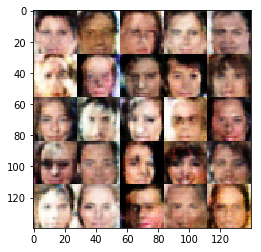

Epoch 1/1	 Batch 1010/1582	 Discriminator Loss: 1.3833	 Generator Loss: 1.0251	
Epoch 1/1	 Batch 1020/1582	 Discriminator Loss: 1.3561	 Generator Loss: 0.6789	
Epoch 1/1	 Batch 1030/1582	 Discriminator Loss: 1.4192	 Generator Loss: 0.6822	
Epoch 1/1	 Batch 1040/1582	 Discriminator Loss: 1.3739	 Generator Loss: 0.7570	
Epoch 1/1	 Batch 1050/1582	 Discriminator Loss: 1.5901	 Generator Loss: 0.4715	
Epoch 1/1	 Batch 1060/1582	 Discriminator Loss: 1.4622	 Generator Loss: 0.6595	
Epoch 1/1	 Batch 1070/1582	 Discriminator Loss: 1.3931	 Generator Loss: 0.8581	
Epoch 1/1	 Batch 1080/1582	 Discriminator Loss: 1.3788	 Generator Loss: 0.8538	
Epoch 1/1	 Batch 1090/1582	 Discriminator Loss: 1.3748	 Generator Loss: 0.8059	
Epoch 1/1	 Batch 1100/1582	 Discriminator Loss: 1.3495	 Generator Loss: 0.9044	


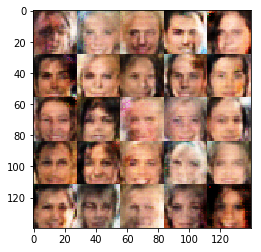

Epoch 1/1	 Batch 1110/1582	 Discriminator Loss: 1.4522	 Generator Loss: 0.5496	
Epoch 1/1	 Batch 1120/1582	 Discriminator Loss: 1.3511	 Generator Loss: 0.8182	
Epoch 1/1	 Batch 1130/1582	 Discriminator Loss: 1.4610	 Generator Loss: 1.1847	
Epoch 1/1	 Batch 1140/1582	 Discriminator Loss: 1.4615	 Generator Loss: 1.1685	
Epoch 1/1	 Batch 1150/1582	 Discriminator Loss: 1.4569	 Generator Loss: 0.5756	
Epoch 1/1	 Batch 1160/1582	 Discriminator Loss: 1.3787	 Generator Loss: 0.9098	
Epoch 1/1	 Batch 1170/1582	 Discriminator Loss: 1.3627	 Generator Loss: 0.6981	
Epoch 1/1	 Batch 1180/1582	 Discriminator Loss: 1.3655	 Generator Loss: 0.9338	
Epoch 1/1	 Batch 1190/1582	 Discriminator Loss: 1.4989	 Generator Loss: 0.5880	
Epoch 1/1	 Batch 1200/1582	 Discriminator Loss: 1.3994	 Generator Loss: 0.9968	


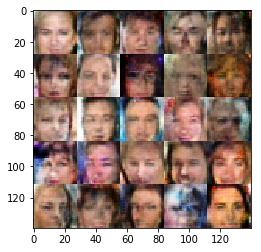

Epoch 1/1	 Batch 1210/1582	 Discriminator Loss: 1.3452	 Generator Loss: 1.0221	
Epoch 1/1	 Batch 1220/1582	 Discriminator Loss: 1.4600	 Generator Loss: 0.5688	
Epoch 1/1	 Batch 1230/1582	 Discriminator Loss: 1.3066	 Generator Loss: 0.7255	
Epoch 1/1	 Batch 1240/1582	 Discriminator Loss: 1.3851	 Generator Loss: 0.7214	
Epoch 1/1	 Batch 1250/1582	 Discriminator Loss: 1.4070	 Generator Loss: 0.6784	
Epoch 1/1	 Batch 1260/1582	 Discriminator Loss: 1.4431	 Generator Loss: 0.5857	
Epoch 1/1	 Batch 1270/1582	 Discriminator Loss: 1.3583	 Generator Loss: 0.7355	
Epoch 1/1	 Batch 1280/1582	 Discriminator Loss: 1.4893	 Generator Loss: 0.5906	
Epoch 1/1	 Batch 1290/1582	 Discriminator Loss: 1.3824	 Generator Loss: 0.7798	
Epoch 1/1	 Batch 1300/1582	 Discriminator Loss: 1.4657	 Generator Loss: 0.6565	


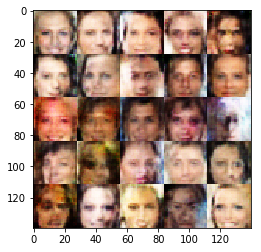

Epoch 1/1	 Batch 1310/1582	 Discriminator Loss: 1.3659	 Generator Loss: 0.7261	
Epoch 1/1	 Batch 1320/1582	 Discriminator Loss: 1.4457	 Generator Loss: 0.6072	
Epoch 1/1	 Batch 1330/1582	 Discriminator Loss: 1.4520	 Generator Loss: 0.5233	
Epoch 1/1	 Batch 1340/1582	 Discriminator Loss: 1.3336	 Generator Loss: 0.9365	
Epoch 1/1	 Batch 1350/1582	 Discriminator Loss: 1.3971	 Generator Loss: 0.8565	
Epoch 1/1	 Batch 1360/1582	 Discriminator Loss: 1.4083	 Generator Loss: 1.1492	
Epoch 1/1	 Batch 1370/1582	 Discriminator Loss: 1.4224	 Generator Loss: 0.9044	
Epoch 1/1	 Batch 1380/1582	 Discriminator Loss: 1.3991	 Generator Loss: 0.7889	
Epoch 1/1	 Batch 1390/1582	 Discriminator Loss: 1.5991	 Generator Loss: 1.5001	
Epoch 1/1	 Batch 1400/1582	 Discriminator Loss: 1.4781	 Generator Loss: 0.5219	


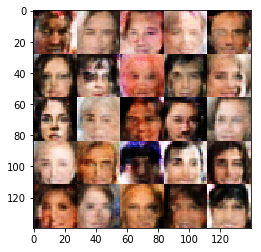

Epoch 1/1	 Batch 1410/1582	 Discriminator Loss: 1.3937	 Generator Loss: 0.8038	
Epoch 1/1	 Batch 1420/1582	 Discriminator Loss: 1.4136	 Generator Loss: 1.1317	
Epoch 1/1	 Batch 1430/1582	 Discriminator Loss: 1.1904	 Generator Loss: 0.7557	
Epoch 1/1	 Batch 1440/1582	 Discriminator Loss: 2.8282	 Generator Loss: 2.2768	
Epoch 1/1	 Batch 1450/1582	 Discriminator Loss: 1.4364	 Generator Loss: 0.8608	
Epoch 1/1	 Batch 1460/1582	 Discriminator Loss: 1.4132	 Generator Loss: 0.9846	
Epoch 1/1	 Batch 1470/1582	 Discriminator Loss: 1.4210	 Generator Loss: 0.7374	
Epoch 1/1	 Batch 1480/1582	 Discriminator Loss: 1.4414	 Generator Loss: 0.6820	
Epoch 1/1	 Batch 1490/1582	 Discriminator Loss: 1.4423	 Generator Loss: 0.7173	
Epoch 1/1	 Batch 1500/1582	 Discriminator Loss: 1.3905	 Generator Loss: 0.8398	


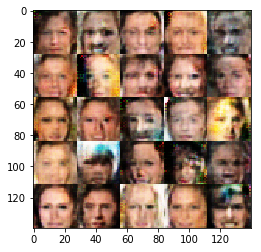

Epoch 1/1	 Batch 1510/1582	 Discriminator Loss: 1.3949	 Generator Loss: 0.8625	
Epoch 1/1	 Batch 1520/1582	 Discriminator Loss: 1.3608	 Generator Loss: 0.8894	
Epoch 1/1	 Batch 1530/1582	 Discriminator Loss: 1.3561	 Generator Loss: 0.8184	
Epoch 1/1	 Batch 1540/1582	 Discriminator Loss: 1.3756	 Generator Loss: 0.8962	
Epoch 1/1	 Batch 1550/1582	 Discriminator Loss: 1.3765	 Generator Loss: 0.8266	
Epoch 1/1	 Batch 1560/1582	 Discriminator Loss: 1.3701	 Generator Loss: 0.8740	
Epoch 1/1	 Batch 1570/1582	 Discriminator Loss: 1.3751	 Generator Loss: 0.8220	
Epoch 1/1	 Batch 1580/1582	 Discriminator Loss: 1.3782	 Generator Loss: 0.7986	


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.